In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model_h as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [4]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [5]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 0, 10: 8, 11: 6, 12: 0, 13: 7, 14: 5, 15: 8, 16: 0, 17: 9, 18: 10, 19: 11, 20: 0, 21: 12, 22: 0, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [6]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGOGN1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGOGN1_Bedroom_id0
3FO4MMIGOGN1_Bedroom_id1
3FO4MMIGOGN1_Bedroom_id2
3FO4MMIGOGN1_Bedroom_id3
3FO4MMIGOGN1_Bedroom_id4
3FO4MMIGOGN1_Bedroom_id5
3FO4MMIGOGN1_Bedroom_id6
3FO4MMIGOGN1_Bedroom_id7
3FO4MMIGOGN1_Bedroom_id8
3FO4MMIGOGN1_Bedroom_id9
3FO4MMIGOGN1_Bedroom_id10
3FO4MMIGOGN1_Bedroom_id11
3FO4MMIGOGN1_Bedroom_id12
3FO4MMIGOGN1_Bedroom_id13
3FO4MMIGOGN1_Bedroom_id14
3FO4MMIGOGN1_Bedroom_id15
3FO4MMIGOGN1_Bedroom_id16
3FO4MMIGOGN1_Bedroom_id17
3FO4MMIGOGN1_Bedroom_id18
3FO4MMIGOGN1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6CI92_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6CI92_Living_room_id0
3FO4MKV6CI92_Living_room_id1
3FO4MKV6CI92_Living_room

3FO4MMH005SW_Bedroom_id6
3FO4MMH005SW_Bedroom_id7
3FO4MMH005SW_Bedroom_id8
3FO4MMH005SW_Bedroom_id9
3FO4MMH005SW_Bedroom_id10
3FO4MMH005SW_Bedroom_id11
3FO4MMH005SW_Bedroom_id12
3FO4MMH005SW_Bedroom_id13
3FO4MMH005SW_Bedroom_id14
3FO4MMH005SW_Bedroom_id15
3FO4MMH005SW_Bedroom_id16
3FO4MMH005SW_Bedroom_id17
3FO4MMH005SW_Bedroom_id18
3FO4MMH005SW_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFI67Q2A_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFI67Q2A_Living_room_id0
3FO4MFI67Q2A_Living_room_id1
3FO4MFI67Q2A_Living_room_id2
3FO4MFI67Q2A_Living_room_id3
3FO4MFI67Q2A_Living_room_id4
3FO4MFI67Q2A_Living_room_id5
3FO4MFI67Q2A_Living_room_id6
3FO4MFI67Q2A_Living_room_id8
3FO4MFI67Q2A_Living_room_id9
3FO4MFI67Q2A_Living_room_id10
3FO4MFI67Q2A_Living_room_id11
3FO4MFI67Q2A_Living_room_id12
3FO4MFI67Q2A_Living_room_id13
3FO4MFI67Q2A_Living_room_id14
3FO4MFI67Q2A_Living_room_id15
3FO4MFI67Q2A_Living_room_

3FO4MIW3FNLI_Living_room_id2
3FO4MIW3FNLI_Living_room_id3
3FO4MIW3FNLI_Living_room_id4
3FO4MIW3FNLI_Living_room_id5
3FO4MIW3FNLI_Living_room_id6
3FO4MIW3FNLI_Living_room_id7
3FO4MIW3FNLI_Living_room_id8
3FO4MIW3FNLI_Living_room_id9
3FO4MIW3FNLI_Living_room_id10
3FO4MIW3FNLI_Living_room_id11
3FO4MIW3FNLI_Living_room_id12
3FO4MIW3FNLI_Living_room_id13
3FO4MIW3FNLI_Living_room_id14
3FO4MIW3FNLI_Living_room_id15
3FO4MIW3FNLI_Living_room_id16
3FO4MIW3FNLI_Living_room_id17
3FO4MIW3FNLI_Living_room_id18
3FO4MIW3FNLI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBE2H2GU_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBE2H2GU_Dining_room_id0
3FO4MBE2H2GU_Dining_room_id1
3FO4MBE2H2GU_Dining_room_id2
3FO4MBE2H2GU_Dining_room_id3
3FO4MBE2H2GU_Dining_room_id4
3FO4MBE2H2GU_Dining_room_id5
3FO4MBE2H2GU_Dining_room_id6
3FO4MBE2H2GU_Dining_room_id7
3FO4MBE2H2GU_Dining_room_id8
3FO4MBE2H2GU_Dining_room_id9
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4MJ4CF2F3_Living_room_id0
3FO4MJ4CF2F3_Living_room_id1
3FO4MJ4CF2F3_Living_room_id2
3FO4MJ4CF2F3_Living_room_id3
3FO4MJ4CF2F3_Living_room_id4
3FO4MJ4CF2F3_Living_room_id5
3FO4MJ4CF2F3_Living_room_id6
3FO4MJ4CF2F3_Living_room_id7
3FO4MJ4CF2F3_Living_room_id8
3FO4MJ4CF2F3_Living_room_id9
3FO4MJ4CF2F3_Living_room_id10
3FO4MJ4CF2F3_Living_room_id11
3FO4MJ4CF2F3_Living_room_id12
3FO4MJ4CF2F3_Living_room_id13
3FO4MJ4CF2F3_Living_room_id14
3FO4MJ4CF2F3_Living_room_id15
3FO4MJ4CF2F3_Living_room_id16
3FO4MJ4CF2F3_Living_room_id17
3FO4MJ4CF2F3_Living_room_id18
3FO4MJ4CF2F3_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4R6P4KS_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4R6P4KS_Guest_room_id0
3FO4M4R6P4KS_Guest_room_id1
3FO4M4R6P4KS_Guest_room_id2
3FO4M4R6P4KS_Guest_room_id3
3FO4M4R6P4KS_Guest_room_id6
3FO4M4R6P4KS_Guest_room_id8
3FO4M4R6P4KS_Guest_ro

3FO4MM1UORDH_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNXR7X0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNXR7X0_Living_room_id0
3FO4MHNXR7X0_Living_room_id1
3FO4MHNXR7X0_Living_room_id2
3FO4MHNXR7X0_Living_room_id3
3FO4MHNXR7X0_Living_room_id4
3FO4MHNXR7X0_Living_room_id5
3FO4MHNXR7X0_Living_room_id6
3FO4MHNXR7X0_Living_room_id7
3FO4MHNXR7X0_Living_room_id8
3FO4MHNXR7X0_Living_room_id9
3FO4MHNXR7X0_Living_room_id10
3FO4MHNXR7X0_Living_room_id11
3FO4MHNXR7X0_Living_room_id12
3FO4MHNXR7X0_Living_room_id13
3FO4MHNXR7X0_Living_room_id14
3FO4MHNXR7X0_Living_room_id15
3FO4MHNXR7X0_Living_room_id16
3FO4MHNXR7X0_Living_room_id17
3FO4MHNXR7X0_Living_room_id18
3FO4MHNXR7X0_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEV76WSI_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEV76WSI_Living_room_id0
3FO4MEV

3FO4MM9YHE42_Living_room_id0
3FO4MM9YHE42_Living_room_id1
3FO4MM9YHE42_Living_room_id2
3FO4MM9YHE42_Living_room_id3
3FO4MM9YHE42_Living_room_id4
3FO4MM9YHE42_Living_room_id5
3FO4MM9YHE42_Living_room_id6
3FO4MM9YHE42_Living_room_id7
3FO4MM9YHE42_Living_room_id8
3FO4MM9YHE42_Living_room_id9
3FO4MM9YHE42_Living_room_id10
3FO4MM9YHE42_Living_room_id11
3FO4MM9YHE42_Living_room_id12
3FO4MM9YHE42_Living_room_id13
3FO4MM9YHE42_Living_room_id14
3FO4MM9YHE42_Living_room_id15
3FO4MM9YHE42_Living_room_id16
3FO4MM9YHE42_Living_room_id17
3FO4MM9YHE42_Living_room_id18
3FO4MM9YHE42_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5FU677_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG5FU677_Living_room_id1
3FO4MG5FU677_Living_room_id2
3FO4MG5FU677_Living_room_id3
3FO4MG5FU677_Living_room_id4
3FO4MG5FU677_Living_room_id5
3FO4MG5FU677_Living_room_id6
3FO4MG5FU677_Living_room_id7
3FO4MG5FU677_Living_room_id8
3FO4

3FO4MKUV144Y_Living_room_id10
3FO4MKUV144Y_Living_room_id11
3FO4MKUV144Y_Living_room_id12
3FO4MKUV144Y_Living_room_id13
3FO4MKUV144Y_Living_room_id14
3FO4MKUV144Y_Living_room_id15
3FO4MKUV144Y_Living_room_id16
3FO4MKUV144Y_Living_room_id17
3FO4MKUV144Y_Living_room_id18
3FO4MKUV144Y_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHWN7G7O_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHWN7G7O_Living_room_id0
3FO4MHWN7G7O_Living_room_id1
3FO4MHWN7G7O_Living_room_id2
3FO4MHWN7G7O_Living_room_id3
3FO4MHWN7G7O_Living_room_id4
3FO4MHWN7G7O_Living_room_id5
3FO4MHWN7G7O_Living_room_id6
3FO4MHWN7G7O_Living_room_id7
3FO4MHWN7G7O_Living_room_id8
3FO4MHWN7G7O_Living_room_id9
3FO4MHWN7G7O_Living_room_id10
3FO4MHWN7G7O_Living_room_id11
3FO4MHWN7G7O_Living_room_id12
3FO4MHWN7G7O_Living_room_id13
3FO4MHWN7G7O_Living_room_id14
3FO4MHWN7G7O_Living_room_id15
3FO4MHWN7G7O_Living_room_id16
3FO4MHWN7G7O_Living_room_i

Done (t=0.00s)
creating index...
index created!
3FO4MEYJA827_Living_room_id0
3FO4MEYJA827_Living_room_id1
3FO4MEYJA827_Living_room_id2
3FO4MEYJA827_Living_room_id3
3FO4MEYJA827_Living_room_id4
3FO4MEYJA827_Living_room_id5
3FO4MEYJA827_Living_room_id6
3FO4MEYJA827_Living_room_id7
3FO4MEYJA827_Living_room_id8
3FO4MEYJA827_Living_room_id9
3FO4MEYJA827_Living_room_id10
3FO4MEYJA827_Living_room_id11
3FO4MEYJA827_Living_room_id12
3FO4MEYJA827_Living_room_id13
3FO4MEYJA827_Living_room_id14
3FO4MEYJA827_Living_room_id15
3FO4MEYJA827_Living_room_id16
3FO4MEYJA827_Living_room_id17
3FO4MEYJA827_Living_room_id18
3FO4MEYJA827_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MILKI858_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MILKI858_Living_room_id0
3FO4MILKI858_Living_room_id1
3FO4MILKI858_Living_room_id2
3FO4MILKI858_Living_room_id3
3FO4MILKI858_Living_room_id4
3FO4MILKI858_Living_room_id5
3FO4MILKI858_L

Done (t=0.00s)
creating index...
index created!
3FO4MLXTBTF2_Living_room_id0
3FO4MLXTBTF2_Living_room_id1
3FO4MLXTBTF2_Living_room_id2
3FO4MLXTBTF2_Living_room_id3
3FO4MLXTBTF2_Living_room_id4
3FO4MLXTBTF2_Living_room_id5
3FO4MLXTBTF2_Living_room_id6
3FO4MLXTBTF2_Living_room_id7
3FO4MLXTBTF2_Living_room_id8
3FO4MLXTBTF2_Living_room_id9
3FO4MLXTBTF2_Living_room_id10
3FO4MLXTBTF2_Living_room_id11
3FO4MLXTBTF2_Living_room_id12
3FO4MLXTBTF2_Living_room_id13
3FO4MLXTBTF2_Living_room_id14
3FO4MLXTBTF2_Living_room_id15
3FO4MLXTBTF2_Living_room_id16
3FO4MLXTBTF2_Living_room_id17
3FO4MLXTBTF2_Living_room_id18
3FO4MLXTBTF2_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBWR8MUK_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBWR8MUK_Dining_room_id0
3FO4MBWR8MUK_Dining_room_id1
3FO4MBWR8MUK_Dining_room_id2
3FO4MBWR8MUK_Dining_room_id3
3FO4MBWR8MUK_Dining_room_id4
3FO4MBWR8MUK_Dining_room_id5
3FO4MBWR8MUK_D

3FO4MIID3AKE_Guest_room_id0
3FO4MIID3AKE_Guest_room_id1
3FO4MIID3AKE_Guest_room_id2
3FO4MIID3AKE_Guest_room_id3
3FO4MIID3AKE_Guest_room_id4
3FO4MIID3AKE_Guest_room_id5
3FO4MIID3AKE_Guest_room_id6
3FO4MIID3AKE_Guest_room_id7
3FO4MIID3AKE_Guest_room_id8
3FO4MIID3AKE_Guest_room_id9
3FO4MIID3AKE_Guest_room_id10
3FO4MIID3AKE_Guest_room_id11
3FO4MIID3AKE_Guest_room_id12
3FO4MIID3AKE_Guest_room_id13
3FO4MIID3AKE_Guest_room_id14
3FO4MIID3AKE_Guest_room_id15
3FO4MIID3AKE_Guest_room_id16
3FO4MIID3AKE_Guest_room_id17
3FO4MIID3AKE_Guest_room_id18
3FO4MIID3AKE_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFNMKHNE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFNMKHNE_Living_room_id0
3FO4MFNMKHNE_Living_room_id1
3FO4MFNMKHNE_Living_room_id2
3FO4MFNMKHNE_Living_room_id3
3FO4MFNMKHNE_Living_room_id4
3FO4MFNMKHNE_Living_room_id5
3FO4MFNMKHNE_Living_room_id6
3FO4MFNMKHNE_Living_room_id7
3FO4MFNMKHNE_Living_room

3FO4MAYK6ANL_Dining_room_id18
3FO4MAYK6ANL_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFR4XJKC_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFR4XJKC_Living_room_id0
3FO4MFR4XJKC_Living_room_id1
3FO4MFR4XJKC_Living_room_id2
3FO4MFR4XJKC_Living_room_id3
3FO4MFR4XJKC_Living_room_id4
3FO4MFR4XJKC_Living_room_id5
3FO4MFR4XJKC_Living_room_id6
3FO4MFR4XJKC_Living_room_id7
3FO4MFR4XJKC_Living_room_id8
3FO4MFR4XJKC_Living_room_id9
3FO4MFR4XJKC_Living_room_id10
3FO4MFR4XJKC_Living_room_id11
3FO4MFR4XJKC_Living_room_id12
3FO4MFR4XJKC_Living_room_id13
3FO4MFR4XJKC_Living_room_id14
3FO4MFR4XJKC_Living_room_id15
3FO4MFR4XJKC_Living_room_id16
3FO4MFR4XJKC_Living_room_id17
3FO4MFR4XJKC_Living_room_id18
3FO4MFR4XJKC_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFVM7W0J_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO

Done (t=0.00s)
creating index...
index created!
3FO4MGAI7D1L_Dining_room_id0
3FO4MGAI7D1L_Dining_room_id1
3FO4MGAI7D1L_Dining_room_id2
3FO4MGAI7D1L_Dining_room_id3
3FO4MGAI7D1L_Dining_room_id4
3FO4MGAI7D1L_Dining_room_id5
3FO4MGAI7D1L_Dining_room_id6
3FO4MGAI7D1L_Dining_room_id7
3FO4MGAI7D1L_Dining_room_id8
3FO4MGAI7D1L_Dining_room_id9
3FO4MGAI7D1L_Dining_room_id10
3FO4MGAI7D1L_Dining_room_id11
3FO4MGAI7D1L_Dining_room_id12
3FO4MGAI7D1L_Dining_room_id13
3FO4MGAI7D1L_Dining_room_id14
3FO4MGAI7D1L_Dining_room_id15
3FO4MGAI7D1L_Dining_room_id16
3FO4MGAI7D1L_Dining_room_id17
3FO4MGAI7D1L_Dining_room_id18
3FO4MGAI7D1L_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1UKXMC_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1UKXMC_Bedroom_id0
3FO4MM1UKXMC_Bedroom_id1
3FO4MM1UKXMC_Bedroom_id2
3FO4MM1UKXMC_Bedroom_id3
3FO4MM1UKXMC_Bedroom_id4
3FO4MM1UKXMC_Bedroom_id5
3FO4MM1UKXMC_Bedroom_id6
3FO4MM1UKXMC_Bedr

Done (t=0.09s)
creating index...
index created!
3FO4MK8FINGQ_Dining_room_id0
3FO4MK8FINGQ_Dining_room_id1
3FO4MK8FINGQ_Dining_room_id2
3FO4MK8FINGQ_Dining_room_id3
3FO4MK8FINGQ_Dining_room_id4
3FO4MK8FINGQ_Dining_room_id5
3FO4MK8FINGQ_Dining_room_id6
3FO4MK8FINGQ_Dining_room_id7
3FO4MK8FINGQ_Dining_room_id8
3FO4MK8FINGQ_Dining_room_id9
3FO4MK8FINGQ_Dining_room_id10
3FO4MK8FINGQ_Dining_room_id11
3FO4MK8FINGQ_Dining_room_id12
3FO4MK8FINGQ_Dining_room_id13
3FO4MK8FINGQ_Dining_room_id14
3FO4MK8FINGQ_Dining_room_id15
3FO4MK8FINGQ_Dining_room_id16
3FO4MK8FINGQ_Dining_room_id17
3FO4MK8FINGQ_Dining_room_id18
3FO4MK8FINGQ_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMJNA0UC_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMJNA0UC_Bedroom_id0
3FO4MMJNA0UC_Bedroom_id1
3FO4MMJNA0UC_Bedroom_id2
3FO4MMJNA0UC_Bedroom_id3
3FO4MMJNA0UC_Bedroom_id4
3FO4MMJNA0UC_Bedroom_id5
3FO4MMJNA0UC_Bedroom_id6
3FO4MMJNA0UC_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4MCY41922_Dining_room_id0
3FO4MCY41922_Dining_room_id1
3FO4MCY41922_Dining_room_id2
3FO4MCY41922_Dining_room_id3
3FO4MCY41922_Dining_room_id4
3FO4MCY41922_Dining_room_id5
3FO4MCY41922_Dining_room_id6
3FO4MCY41922_Dining_room_id7
3FO4MCY41922_Dining_room_id8
3FO4MCY41922_Dining_room_id9
3FO4MCY41922_Dining_room_id10
3FO4MCY41922_Dining_room_id11
3FO4MCY41922_Dining_room_id12
3FO4MCY41922_Dining_room_id13
3FO4MCY41922_Dining_room_id14
3FO4MCY41922_Dining_room_id15
3FO4MCY41922_Dining_room_id16
3FO4MCY41922_Dining_room_id17
3FO4MCY41922_Dining_room_id18
3FO4MCY41922_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHOOUBM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHOOUBM_Living_room_id0
3FO4MIHOOUBM_Living_room_id1
3FO4MIHOOUBM_Living_room_id2
3FO4MIHOOUBM_Living_room_id3
3FO4MIHOOUBM_Living_room_id4
3FO4MIHOOUBM_Living_room_id5
3FO4MIHOOUBM_L

HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGGJEONH_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGGJEONH_Guest_room_id0
3FO4JGGJEONH_Guest_room_id1
3FO4JGGJEONH_Guest_room_id2
3FO4JGGJEONH_Guest_room_id3
3FO4JGGJEONH_Guest_room_id4
3FO4JGGJEONH_Guest_room_id5
3FO4JGGJEONH_Guest_room_id6
3FO4JGGJEONH_Guest_room_id7
3FO4JGGJEONH_Guest_room_id8
3FO4JGGJEONH_Guest_room_id9
3FO4JGGJEONH_Guest_room_id10
3FO4JGGJEONH_Guest_room_id11
3FO4JGGJEONH_Guest_room_id12
3FO4JGGJEONH_Guest_room_id14
3FO4JGGJEONH_Guest_room_id15
3FO4JGGJEONH_Guest_room_id18
3FO4JGGJEONH_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGDHA0H2_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGDHA0H2_Living_room_id0
3FO4JGDHA0H2_Living_room_id1
3FO4JGDHA0H2_Living_room_id2
3FO4JGDHA0H2_Living_room_id3
3FO4JGDHA0H2_Living_room_id4
3FO4JGDHA0H2_Living_room_

Done (t=0.00s)
creating index...
index created!
3FO4JGRFJBT0_Bedroom_id0
3FO4JGRFJBT0_Bedroom_id1
3FO4JGRFJBT0_Bedroom_id2
3FO4JGRFJBT0_Bedroom_id3
3FO4JGRFJBT0_Bedroom_id4
3FO4JGRFJBT0_Bedroom_id5
3FO4JGRFJBT0_Bedroom_id6
3FO4JGRFJBT0_Bedroom_id7
3FO4JGRFJBT0_Bedroom_id8
3FO4JGRFJBT0_Bedroom_id9
3FO4JGRFJBT0_Bedroom_id10
3FO4JGRFJBT0_Bedroom_id11
3FO4JGRFJBT0_Bedroom_id14
3FO4JGRFJBT0_Bedroom_id15
3FO4JGRFJBT0_Bedroom_id16
3FO4JGRFJBT0_Bedroom_id17
3FO4JGRFJBT0_Bedroom_id18
3FO4JGRFJBT0_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JHOQ4OQE_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JHOQ4OQE_Guest_room_id0
3FO4JHOQ4OQE_Guest_room_id1
3FO4JHOQ4OQE_Guest_room_id2
3FO4JHOQ4OQE_Guest_room_id3
3FO4JHOQ4OQE_Guest_room_id4
3FO4JHOQ4OQE_Guest_room_id5
3FO4JHOQ4OQE_Guest_room_id6
3FO4JHOQ4OQE_Guest_room_id7
3FO4JHOQ4OQE_Guest_room_id8
3FO4JHOQ4OQE_Guest_room_id9
3FO4JHOQ4OQE_Guest_room_id10
3FO4JHOQ4OQE_G

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5406A3_Living_room/./cam0/data/3.png
7384


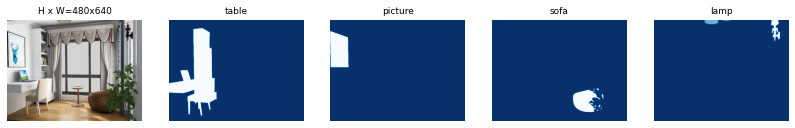

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5406A3_Living_room/./cam0/data/1.png
7382


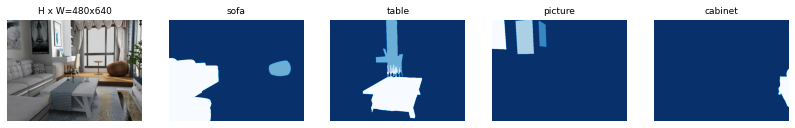

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5406A3_Living_room/./cam0/data/18.png
7399


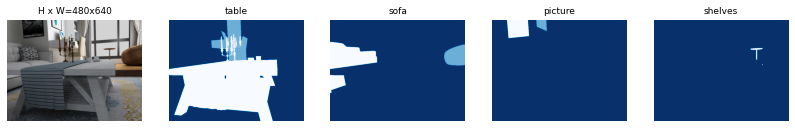

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5406A3_Living_room/./cam0/data/13.png
7394


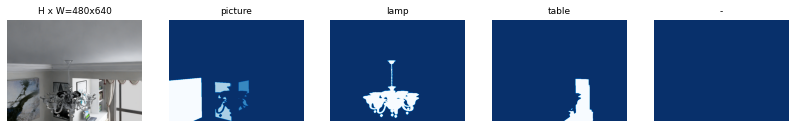

In [15]:
def masks2instance_im(masks):
    instance_im = np.zeros(shape=[masks.shape[0], masks.shape[1]])
    for i in range(masks.shape[-1]):
        instance_im[masks[...,i]] = (i + 1)
    return instance_im

image_ids = dataset_train.load_view(4)
images = []
masks = []
for image_id in image_ids:
    print(dataset_train.image_info[image_id]['path'])
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    plt.imsave(os.path.join(ROOT_DIR, 'data/Results/{}_mask.png'.format(image_id)), masks2instance_im(mask))
    plt.imsave(os.path.join(ROOT_DIR, 'data/Results/{}.png'.format(image_id)), image)

    im = visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    

In [ ]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 8000
    VALIDATION_STEPS = 1000
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.07
    vmax = 1.07
    nvox = 40
    nvox_z = 40
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 10
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    LEARNING_RATE = 0.001
    GRID_REAS = 'ident'
    BACKBONE = 'resnet50'
#     TOP_DOWN_PYRAMID_SIZE = 64

config_stage1 = TrainConfig()
config_stage1.display()

In [ ]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess= tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config_stage1,
                          model_dir=MODEL_DIR)
#model.load_weights(model_path, by_name=True)
print(model.keras_model.summary())
# Load pretrained weights
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
# model.keras_model.save_weights(os.path.join(MODEL_DIR, 'interionet.h5'))

In [ ]:
# This schedule overwrites the learning rate in config
def step_decay(epoch):
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 6
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        if lrate < 0.001:
            return 0.001
        return lrate
lrate = LearningRateScheduler(step_decay)

callbacks_list = [lrate]

In [ ]:
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=MODEL_DIR, histogram_freq=1)


In [ ]:
# Add all callbacks to list
# from keras.backend.tensorflow_backend import set_session
# config_tf = tf.ConfigProto()
# config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config_tf)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [ ]:
# from keras.engine import saving
# import h5py
# f = h5py.File(COCO_MODEL_PATH, mode='r')
# f = h5py.File(os.path.join(MODEL_DIR, 'interiornet20200330T1532', 'mask_rcnn_interiornet_0298.h5'), mode='r')
# for layer in model.keras_model.layers:
#     if layer.name == 'backbone':
#         layers = layer.layers
#         print(layer.__class__.__name__)
#         saving.load_weights_from_hdf5_group_by_name(f, layer.layers)
#         break

In [ ]:
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# model_path = os.path.join(MODEL_DIR, 'stage1', 'interior_sep.h5')
model_path = model.find_last()
#model_path =  COCO_MODEL_PATH
print(model_path)
# model.load_weights(model_path, by_name=True, exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask", "grid_reas_P2/3D_conv", "grid_reas_P3/3D_conv", "grid_reas_P4/3D_conv", "grid_reas_P5/3D_conv", "grid_reas_P6/3D_conv"])
model.load_weights(model_path, by_name=True)
# model.load_weights(model_path, by_name=True, exclude = ["grid_reas_P2/3D_conv", "grid_reas_P3/3D_conv", "grid_reas_P4/3D_conv", "grid_reas_P5/3D_conv", "grid_reas_P6/3D_conv"])
# model.load_weights(model_path, by_name=True, exclude = ["backbone"])

In [ ]:
print("Train heads and grid reasoning layers")
model.train(dataset_train, dataset_train,
           learning_rate=config_stage1.LEARNING_RATE, custom_callbacks=callbacks_list,
           epochs=20,
           layers='all')
# model.train(dataset_train, dataset_val,
#             learning_rate=config_stage1.LEARNING_RATE,
#             epochs=20,
#             layers='all')

In [ ]:
# print("Train res5+")
# model.train(dataset_train, dataset_val,
#             learning_rate=config_stage1.LEARNING_RATE,
#             epochs=20,
#             layers='5+')

In [ ]:
from keras.engine import saving
import h5py
#f = h5py.File(os.path.join(MODEL_DIR, '', 'backbone_sep.h5'), mode='r')
for layer in model.keras_model.layers:
    if layer.name == 'backbone':
        layer.save_weights(os.path.join(MODEL_DIR, '', 'backbone_sep.h5'))
        break

In [ ]:
image_id = 609
image_t, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    modellib.load_image_gt(dataset_train, config_stage1, image_id, augment=False,
                                  augmentation=None,
                                  use_mini_mask=config_stage1.USE_MINI_MASK)

In [ ]:
plt.imshow(image_t)
#plt.imshow(gt_masks[:,:,0])
print(gt_boxes)
print(image_meta)
print(gt_class_ids)

In [ ]:
a = modellib.data_generator(dataset_train, config_stage1, shuffle=True, augment=False, augmentation=None,
                   random_rois=0, batch_size=1, detection_targets=False,
                   no_augmentation_sources=None)
print(a)

In [ ]:
# inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
#                           batch_gt_class_ids, batch_gt_boxes, batch_gt_masks, batch_gt_R, batch_gt_Kmat]

inputs, output = next(a)
for i, input_i in enumerate(inputs):
    #print("{}'th input is: {}".format(i, input_i))
    print("shape of {}'ths input is: {}".format(i, input_i.shape))


In [ ]:
print(np.where(inputs[2]>0))

In [ ]:
3